# TPOT tutorial on the Titanic dataset 

The Titanic machine learning competition on [Kaggle](https://www.kaggle.com/c/titanic) is one of the most popular beginner's competitions on the platform. We will use that competition here to demonstrate the implementation of TPOT. 

In [1]:
# Import required libraries
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np

In [2]:
# Load the data
titanic = pd.read_csv('data/titanic_train.csv')
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data Exploration 

In [3]:
titanic.groupby('Sex').Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [4]:
titanic.groupby(['Pclass','Sex']).Survived.value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

In [5]:
id = pd.crosstab([titanic.Pclass, titanic.Sex], titanic.Survived.astype(float))
id.div(id.sum(1).astype(float), 0)

Survived            0.0       1.0
Pclass Sex                       
1      female  0.031915  0.968085
       male    0.631148  0.368852
2      female  0.078947  0.921053
       male    0.842593  0.157407
3      female  0.500000  0.500000
       male    0.864553  0.135447

## Data Munging 

The first and most important step in using TPOT on any data set is to rename the target class/response variable to `class`.

In [6]:
titanic.rename(columns={'Survived': 'class'}, inplace=True)

At present, TPOT requires all the data to be in numerical format. As we can see below, our data set has 5 categorical variables which contain non-numerical values: `Name`, `Sex`, `Ticket`, `Cabin` and `Embarked`.

In [7]:
titanic.dtypes

PassengerId      int64
class            int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

We then check the number of levels that each of the five categorical variables have. 

In [8]:
for cat in ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']:
    print("Number of levels in category '{0}': \b {1:2.2f} ".format(cat, titanic[cat].unique().size))

Number of levels in category 'Name':  891.00 
Number of levels in category 'Sex':  2.00 
Number of levels in category 'Ticket':  681.00 
Number of levels in category 'Cabin':  148.00 
Number of levels in category 'Embarked':  4.00 


As we can see, `Sex` and `Embarked` have few levels. Let's find out what they are.

In [9]:
for cat in ['Sex', 'Embarked']:
    print("Levels for catgeory '{0}': {1}".format(cat, titanic[cat].unique()))

Levels for catgeory 'Sex': ['male' 'female']
Levels for catgeory 'Embarked': ['S' 'C' 'Q' nan]


We then code these levels manually into numerical values. For `nan` i.e. the missing values, we simply replace them with a placeholder value (-999). In fact, we perform this replacement for the entire data set.

In [10]:
titanic['Sex'] = titanic['Sex'].map({'male':0,'female':1})
titanic['Embarked'] = titanic['Embarked'].map({'S':0,'C':1,'Q':2})

In [11]:
titanic = titanic.fillna(-999)
pd.isnull(titanic).any()

PassengerId    False
class          False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

Since `Name` and `Ticket` have so many levels, we drop them from our analysis for the sake of simplicity. For `Cabin`, we encode the levels as digits using Scikit-learn's [`MultiLabelBinarizer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) and treat them as new features. 

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
CabinTrans = mlb.fit_transform([{str(val)} for val in titanic['Cabin'].values])

In [13]:
CabinTrans

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

Drop the unused features from the dataset. 

In [14]:
titanic_new = titanic.drop(['Name','Ticket','Cabin','class'], axis=1)

In [15]:
assert (len(titanic['Cabin'].unique()) == len(mlb.classes_)), "Not Equal" #check correct encoding done

We then add the encoded features to form the final dataset to be used with TPOT. 

In [16]:
titanic_new = np.hstack((titanic_new.values,CabinTrans))

In [17]:
np.isnan(titanic_new).any()

False

Keeping in mind that the final dataset is in the form of a numpy array, we can check the number of features in the final dataset as follows.

In [18]:
titanic_new[0].size

156

Finally we store the class labels, which we need to predict, in a separate variable. 

In [19]:
titanic_class = titanic['class'].values

## Data Analysis using TPOT

To begin our analysis, we need to divide our training data into training and validation sets. The validation set is just to give us an idea of the test set error. The model selection and tuning is entirely taken care of by TPOT, so if we want to, we can skip creating this validation set.

In [20]:
training_indices, validation_indices = training_indices, testing_indices = train_test_split(titanic.index, stratify = titanic_class, train_size=0.75, test_size=0.25)
training_indices.size, validation_indices.size

(668, 223)

After that, we proceed to calling the `fit`, `score` and `export` functions on our training dataset. To get a better idea of how these functions work, refer the TPOT documentation [here](http://epistasislab.github.io/tpot/api/).

An important TPOT parameter to set is the number of generations. Since our aim is to just illustrate the use of TPOT, we have set maximum optimization time to 2 minutes (max_time_mins=2). On a standard laptop with 4GB RAM, it roughly takes 5 minutes per generation to run. For each added generation, it should take 5 mins more. Thus, for the default value of 100, total run time could be roughly around 8 hours.  

In [21]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40)
tpot.fit(titanic_new[training_indices], titanic_class[training_indices])

Optimization Progress: 100%|██████████| 80/80 [00:12<00:00,  6.43pipeline/s]

Generation 1 - Current best internal CV score: 0.8203972618112445


Optimization Progress: 100%|██████████| 120/120 [00:19<00:00,  5.50pipeline/s]

Generation 2 - Current best internal CV score: 0.8203972618112445


Optimization Progress: 100%|██████████| 160/160 [00:32<00:00,  2.99pipeline/s]

Generation 3 - Current best internal CV score: 0.8203972618112445


Optimization Progress: 100%|██████████| 200/200 [00:43<00:00,  6.08pipeline/s]

Generation 4 - Current best internal CV score: 0.8203972618112445


Optimization Progress: 100%|██████████| 240/240 [00:52<00:00,  4.20pipeline/s]

Generation 5 - Current best internal CV score: 0.8203972618112445


Optimization Progress: 100%|██████████| 280/280 [01:03<00:00,  3.62pipeline/s]

Generation 6 - Current best internal CV score: 0.8219341887055946


Optimization Progress: 100%|██████████| 320/320 [01:15<00:00,  3.21pipeline/s]

Generation 7 - Current best internal CV score: 0.8249418737556994


Optimization Progress: 100%|██████████| 360/360 [01:26<00:00,  3.95pipeline/s]

Generation 8 - Current best internal CV score: 0.8249418737556994


Optimization Progress: 100%|██████████| 400/400 [01:38<00:00,  4.84pipeline/s]

Generation 9 - Current best internal CV score: 0.8249418737556994


Optimization Progress: 100%|██████████| 440/440 [01:48<00:00,  3.66pipeline/s]

Generation 10 - Current best internal CV score: 0.8249418737556994


Optimization Progress: 100%|██████████| 480/480 [02:51<00:00,  2.06s/pipeline]

Generation 11 - Current best internal CV score: 0.8249418737556994


                                                           9,  2.05s/pipeline]


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestClassifier(input_matrix, RandomForestClassifier__bootstrap=False, RandomForestClassifier__criterion=DEFAULT, RandomForestClassifier__max_features=0.4, RandomForestClassifier__min_samples_leaf=1, RandomForestClassifier__min_samples_split=9)


In [22]:
tpot.score(titanic_new[validation_indices], titanic.loc[validation_indices, 'class'].values)

0.8340807174887892

In [23]:
tpot.export('tpot_titanic_pipeline.py')

Let's have a look at the generated code. As we can see, the random forest classifier performed the best on the given dataset out of all the other models that TPOT currently evaluates on. If we ran TPOT for more generations, then the score should improve further.

In [ ]:
# %load tpot_titanic_pipeline.py
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_classes, testing_classes = \
            train_test_split(features, tpot_data['target'], random_state=None)

exported_pipeline = RandomForestClassifier(bootstrap=False, max_features=0.4, min_samples_leaf=1, min_samples_split=9)

exported_pipeline.fit(training_features, training_classes)
results = exported_pipeline.predict(testing_features)


### Make predictions on the submission data 

In [25]:
# Read in the submission dataset
titanic_sub = pd.read_csv('data/titanic_test.csv')
titanic_sub.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


The most important step here is to check for new levels in the categorical variables of the submission dataset that are absent in the training set. We identify them and set them to our placeholder value of '-999', i.e., we treat them as missing values. This ensures training consistency, as otherwise the model does not know what to do with the new levels in  the submission dataset. 

In [26]:
for var in ['Cabin']: #,'Name','Ticket']:
    new = list(set(titanic_sub[var]) - set(titanic[var]))
    titanic_sub.ix[titanic_sub[var].isin(new), var] = -999

We then carry out the data munging steps as done earlier for the training dataset.

In [27]:
titanic_sub['Sex'] = titanic_sub['Sex'].map({'male':0,'female':1})
titanic_sub['Embarked'] = titanic_sub['Embarked'].map({'S':0,'C':1,'Q':2})

In [28]:
titanic_sub = titanic_sub.fillna(-999)
pd.isnull(titanic_sub).any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
dtype: bool

While calling `MultiLabelBinarizer` for the submission data set, we first fit on the training set again to learn the levels and then transform the submission dataset values. This further ensures that only those levels that were present in the training dataset are transformed. If new levels are still found in the submission dataset then it will return an error and we need to go back and check our earlier step of replacing new levels with the placeholder value. 

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
SubCabinTrans = mlb.fit([{str(val)} for val in titanic['Cabin'].values]).transform([{str(val)} for val in titanic_sub['Cabin'].values])
titanic_sub = titanic_sub.drop(['Name','Ticket','Cabin'], axis=1)

In [30]:
# Form the new submission data set
titanic_sub_new = np.hstack((titanic_sub.values,SubCabinTrans))

In [31]:
np.any(np.isnan(titanic_sub_new))

False

In [32]:
# Ensure equal number of features in both the final training and submission dataset
assert (titanic_new.shape[1] == titanic_sub_new.shape[1]), "Not Equal" 

In [33]:
# Generate the predictions
submission = tpot.predict(titanic_sub_new)

In [34]:
# Create the submission file
final = pd.DataFrame({'PassengerId': titanic_sub['PassengerId'], 'Survived': submission})
final.to_csv('data/submission.csv', index = False)

In [35]:
final.shape

(418, 2)

There we go! We have successfully generated the predictions for the 418 data points in the submission dataset, and we're good to go ahead to submit these predictions on Kaggle. 

In [8]:
##############################################################################################
# Solo Titanic
##############################################################################################

import pandas as pd
pd.options.display.max_columns = 6
df = pd.read_csv('https://sololearn.com/uploads/files/titanic.csv')
# print(df.describe())
# we want to create a column 
df['male'] = df['Sex'] == 'male'
# print(df.head())
# Converting from a Pandas DataFrame to a Numpy Array
df['Fare'].values
arr = df[['Pclass', 'Fare', 'Age']].values
print(arr.shape)

# take first 10 values for simplicity
arr = df[['Pclass', 'Fare', 'Age']].values[:10]

mask = arr[:, 2] < 18
# print(arr[mask])
# print(arr[arr[:, 2] < 18])
print((arr[:, 2] < 18).sum())

(887, 3)
2


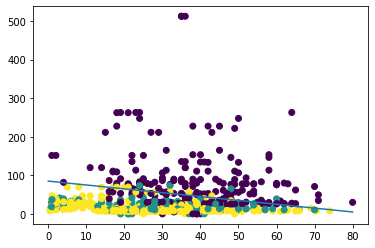

In [11]:
# plotting
import matplotlib.pyplot as plt
plt.scatter(df['Age'], df['Fare'], c=df['Pclass'])
# plotting a line
plt.plot([0, 80], [85, 5])